## Libraries

In [1]:
import pandas as pd
import numpy as np

# for calculating log-returns and simple-returns
from numpy import diff, log, exp

# for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline

# for Jarque-Bera(JB) test(including skew and kurtosis) and probability plots
import scipy.stats as stats
# for Ordinary Least Squares
from statsmodels.formula.api import ols

# for obtaining market data by direct downloading
import datetime
from pandas_datareader import data

# for counting the number of accepting/rejecting null hypothesis
from collections import Counter

--- 

## Import Data

In [2]:
prices = pd.read_csv('s_and_p_100.csv')

In [3]:
prices.head()

,Date,AAPL,ABBV,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,...,UNP,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM
0,2010-01-04,27.406532,NaN,21.194162,35.052402,39.233837,23.243692,25.586843,50.156246,133.899994,...,27.789530,46.125214,19.436718,59.234444,18.397221,21.143955,31.539467,22.523083,44.424107,54.621700
1,2010-01-05,27.453915,NaN,21.022924,35.269032,38.844330,22.808218,26.007540,49.721764,134.690002,...,28.176256,46.204498,19.929434,58.349625,18.186405,21.182079,31.285799,23.141388,43.981754,54.834965
2,2010-01-06,27.017223,NaN,21.139675,35.643974,38.970917,22.660460,26.015955,49.348106,132.250000,...,28.218761,45.863583,20.141808,58.043648,17.942194,20.573015,31.049047,23.174374,43.883450,55.308914
3,2010-01-07,26.967278,NaN,21.314800,35.610645,38.659306,22.224985,26.150579,48.896252,130.000000,...,27.968023,45.514767,20.532579,58.291740,18.109184,20.450558,31.235058,24.015276,43.908028,55.135132
4,2010-01-08,27.146566,NaN,21.423773,35.469002,38.376904,22.815992,26.259966,49.330727,133.520004,...,28.915730,47.702900,20.566551,58.407513,18.159275,20.463448,31.277355,23.792685,43.686840,54.913967


---

## Data Cleansing
Clean the data before moving on by fixing or removing incorrect or incomplete data

In [4]:
# check if NA values exist
hasNaN = prices.columns[prices.isna().any()].tolist()
hasNaN # the column names in this list contain NaN values

['ABBV', 'CHTR', 'COP', 'FB', 'GM', 'JPM', 'KHC', 'KMI', 'PYPL']

In [5]:
# pick columns that have NaN values
NaNData = prices[hasNaN]

# count the number of NaN values in each column
totalNaN = pd.DataFrame(NaNData.apply(lambda x : x.isna().sum()),columns = ["Count"])

# calculate the proportion of NaN values for each column
totalNaN["NaN Proportion (%)"] = totalNaN["Count"]/len(prices)*100
totalNaN

,Count,NaN Proportion (%)
ABBV,754,37.889447
CHTR,1,0.050251
COP,4,0.201005
FB,599,30.100503
GM,222,11.155779
JPM,1,0.050251
KHC,1384,69.547739
KMI,280,14.070352
PYPL,1384,69.547739


In [6]:
# drop columns that have NaN values more than 5%
colsToDrop = list((totalNaN[totalNaN['NaN Proportion (%)'] > 5]).index)
prices.drop(colsToDrop, inplace=True, axis=1)

---

## Exercise 1

Choose a single stock from the index, and compute the corresponding __daily, monthly and annual log-returns__. For each sampling frequency, __test whether the returns are normally distributed__. Include appropriate graphs in your final report and ensure that you clearly explain your analysis in your own words

### Solution 1
> 1. Choose a single stock which is Apple(AAPL) for this example, and update the index for resampling
> 2. Use diff() and log() to calculate log-returns for daily/monthly/annual data where diff() returns output[i] = arr[i+1] - arr[i] and log() returns the natural log value
> 3. Plot graphs for each log-returns
> 4. To check whether the returns are normally distributed, plot Histograms, Kernel Density Estimation (a probability density function) and Probability Plot for each log-return
    - Use KDE as it determines the shape of the distribution more efficiently than histograms
    - KDE does not have to depend on the number of bins used unlike  histograms
    - Use Probability Plot as well since probability plots are more specialised in determining by graphing z-scores (normal scores) against the data set
        * In Probability Plot, data is plotted against the theoretical normal distribution plot such that the plot forms an approximate straight line if the data is normally distributed (referring to: https://www.itl.nist.gov/div898/handbook/eda/section3/probplot.htm)

## Returns based on Frequencies
Referring to:
> https://towardsdatascience.com/calculate-and-plot-s-p-500-daily-returns-2ce359e014d6

> https://factorpad.com/fin/quant-101/calculate-stock-returns.html

> https://finance.zacks.com/stock-return-using-adjusted-closing-price-11628.html

To calculate a {dai/month/annual}_ly stock return
- we compare the __closing price__ to the __closing price from the previous {day/month/year}__

In [7]:
# for resampling, update the index to datetime index
prices['Date'] = pd.to_datetime(prices['Date'])
prices.set_index('Date', inplace=True)

# choose AAPl (Apple stock)
apple_stock = prices['AAPL']

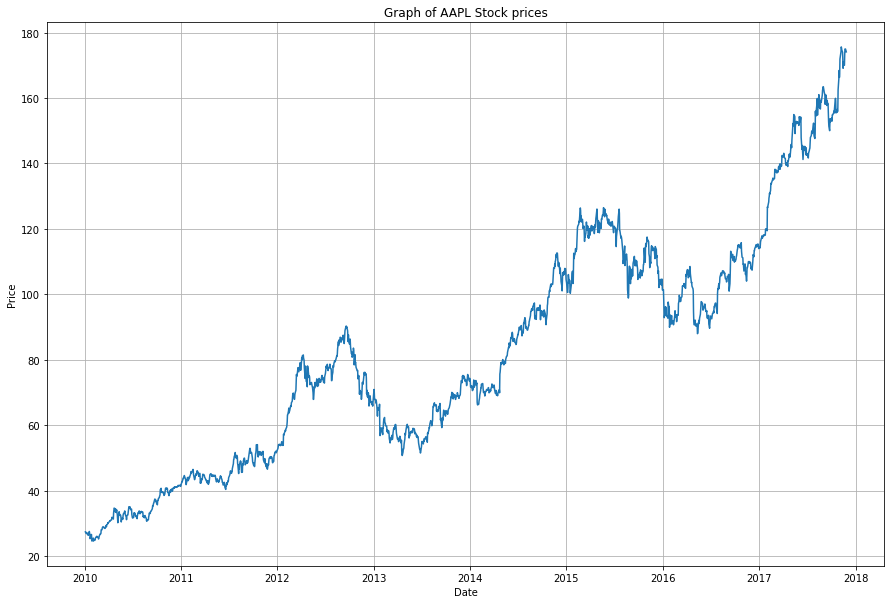

In [8]:
# set the figure size large
f = plt.figure() 
f.set_figwidth(15); f.set_figheight(10)

# plot the AAPL stock prices graph
plt.plot(prices.index,prices.AAPL)

# add grid on the graph
plt.grid()

# label the graph
plt.xlabel("Date"); plt.ylabel("Price")
plt.title("Graph of AAPL Stock prices")
plt.show()

In [9]:
# define a function which returns the log_returns of prices for a given frequency
def log_returns(resampled_prices):
    # calculate log-returns
        # np.diff() function returns an array instead of a DataFrame
        # therefore, convert to series so that time axis have dates
        # update the index from 1: since the first row has no previous data to calculate the difference
    resampled_log_returns = pd.Series(diff(log(resampled_prices)), index=resampled_prices.index[1:])
    return resampled_log_returns

### Daily log-returns

In [10]:
# put sampling frequency = "D" for daily
# -> the data already provides daily data without resampling, but to keep the procedures consistent, put "D"
# use last() for closing price and drop any NaN values for calculation
daily = apple_stock.resample('D').last().dropna()
daily_log_returns = log_returns(daily)

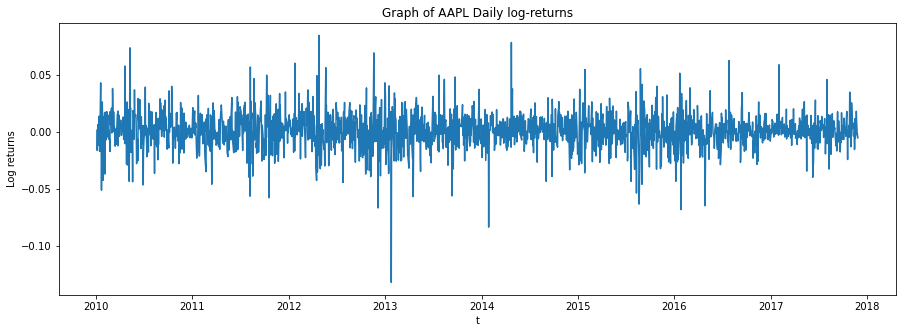

In [11]:
# set the figure size large
f = plt.figure() 
f.set_figwidth(15); f.set_figheight(5)

# plot the AAPL stock prices graph
plt.plot(daily_log_returns)

# label the graph
plt.xlabel("t"); plt.ylabel("Log returns")
plt.title("Graph of AAPL Daily log-returns")
plt.show()

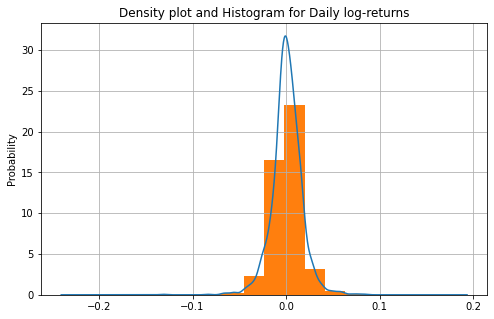

In [12]:
fig, ax = plt.subplots()

# update the size of the plot figure
fig.set_figwidth(8); fig.set_figheight(5)

# plot KDE
daily_log_returns.plot.kde(ax=ax, title='Density plot and Histogram for Daily log-returns')
# plot histogram
daily_log_returns.plot.hist(density=True, ax=ax)

#put label and grid
ax.set_ylabel('Probability'); ax.grid()

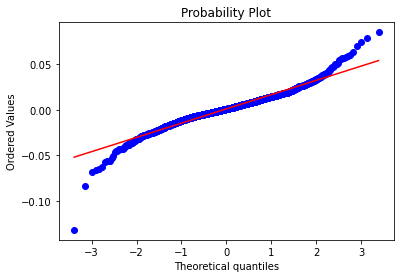

In [13]:
# plot probability plot for daily_log_returns
stats.probplot(daily_log_returns, dist='norm',plot=plt)
plt.show()

> The density plot and histogram above suggests that the daily log-returns are __normally distributed__
> - The mean($\mu$) is around 0.0 and the curve is symmetric at the center
> - There is very little deviation of the histogram from the bell curve KDE distribution

> The probability plot above suggests that the daily log-returns are __normally distributed__
> - The red straight line goes through the data's mean($\mu$) with a slope of the standard deviation($\sigma$) of the data used (referring to https://en.wikipedia.org/wiki/Normal_probability_plot)
> - The blue dots are fairly close to the red straight line ignoring the tails

### Monthly log-returns

In [14]:
# put sampling frequency = "M" for monthly
# use last() for closing price and drop any NaN values for calculation
monthly = apple_stock.resample('M').last().dropna()
monthly_log_returns = log_returns(monthly)

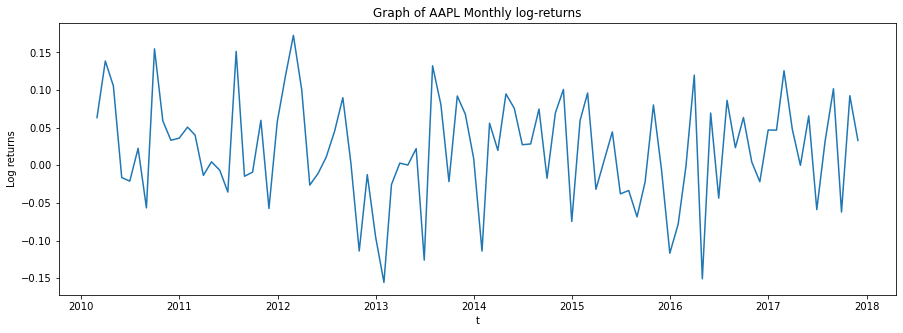

In [15]:
# set the figure size large
f = plt.figure() 
f.set_figwidth(15); f.set_figheight(5)

# plot the AAPL stock prices graph
plt.plot(monthly_log_returns)

# label the graph
plt.xlabel("t"); plt.ylabel("Log returns")
plt.title("Graph of AAPL Monthly log-returns")
plt.show()

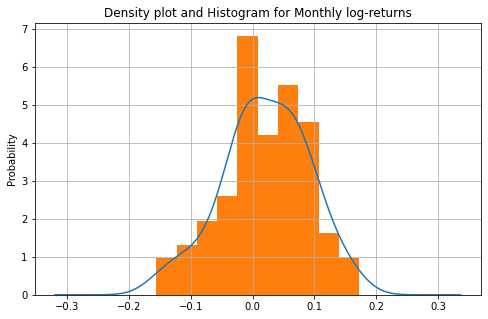

In [16]:
fig, ax = plt.subplots()

# update the size of the plot figure
fig.set_figwidth(8); fig.set_figheight(5)

# plot KDE
monthly_log_returns.plot.kde(ax=ax, title='Density plot and Histogram for Monthly log-returns')

# plot histogram
monthly_log_returns.plot.hist(density=True, ax=ax)

#put label and grid
ax.set_ylabel('Probability'); ax.grid()

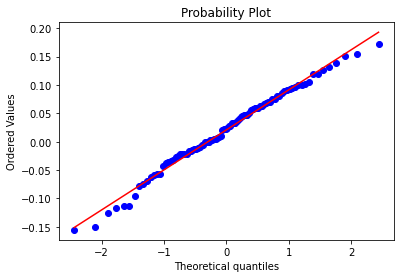

In [17]:
# plot probability plot for monthly_log_returns
stats.probplot(monthly_log_returns, dist='norm',plot=plt)
plt.show()

> The density plot and histogram above suggests that the monthly log-returns are __barely normally distributed__
> - The mean($\mu$) is around 0.0 and the curve is almost symmetric at the center
> - There is a deviation of the histogram from the bell curve KDE distribution although the overall shape follows bell-curved normal distribution

> The probability plot above suggests that the monthly log-returns are __hardly normally distributed__
> - The red straight line goes through the data's mean($\mu$) with a slope of the standard deviation($\sigma$) of the data used (referring to https://en.wikipedia.org/wiki/Normal_probability_plot)
> - The blue dots are fairly close to the red straight line ignoring large range of tails

### Yearly log-returns

In [18]:
# put sampling frequency = "A" for annual
# use last() for closing price and drop any NaN values for calculation
annually = apple_stock.resample("A").last().dropna()
annual_log_returns = log_returns(annually)

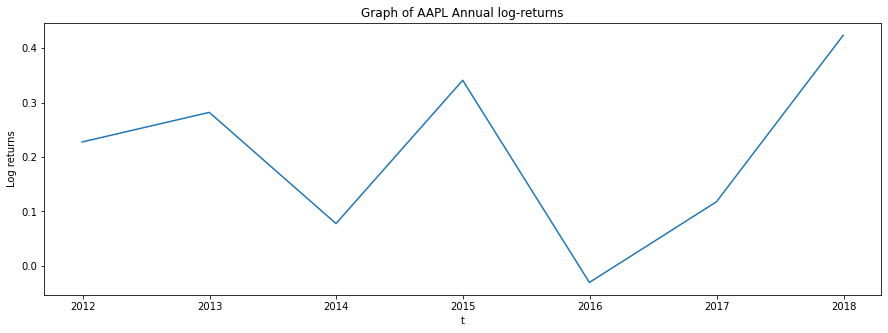

In [19]:
# set the figure size large
f = plt.figure() 
f.set_figwidth(15); f.set_figheight(5)

# plot the AAPL stock prices graph
plt.plot(annual_log_returns)

# label the graph
plt.xlabel("t"); plt.ylabel("Log returns")
plt.title("Graph of AAPL Annual log-returns")
plt.show()

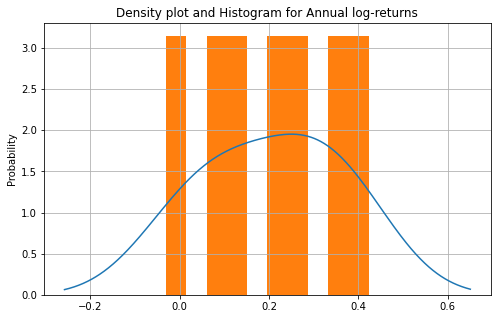

In [20]:
fig, ax = plt.subplots()

# update the size of the plot figure
fig.set_figwidth(8); fig.set_figheight(5)

# plot KDE
annual_log_returns.plot.kde(ax=ax, title='Density plot and Histogram for Annual log-returns')

# plot histogram
annual_log_returns.plot.hist(density=True, ax=ax)

#put label and grid
ax.set_ylabel('Probability'); ax.grid()

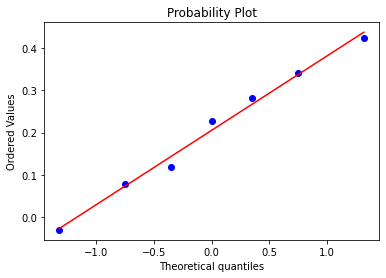

In [21]:
# plot probability plot for annual_log_returns
stats.probplot(annual_log_returns, dist='norm',plot=plt)
plt.show()

> The density plot and histogram above suggests that the annual log-returns are __not normally distributed__
> - The curve is almost symmetric at the centre __but__
> - The shape of the histogram is significantly different from the shape of the density plot and does not display bell-curved shape at all

> The probability plot above suggests that the annual log-returns are __hardly normally distributed__
> - The red straight line goes through the data's mean($\mu$) with a slope of the standard deviation($\sigma$) of the data used (referring to https://en.wikipedia.org/wiki/Normal_probability_plot)
> - The blue dots are fairly close to the red straight line but the lack of sample size barely suggests that the data follows normal distribution

------

## Exercise 2
Compute the __Jarque-Bera test statistic and  $\rho$ -values__ for all stocks in the index __over daily, monthly and annual frequencies__. Summarise your results in a single graph which shows three side-by-side boxplots of the test statistic comparing: __daily, monthly and annual return distributions__. Comment on __whether your results support the claim that stock returns exhibit aggregational Gaussianity__ (see, e.g., Cont 2001; reference below).

### Solution 2
> 1. Import 'jarque_bera' from scipy library for JB test
> 2. Using this library, compute the JB test statistics across different frequencies
> 3. Plot the obtained test statistics of each return distribution as box plots
> 4. Using bootstrapping, compute the JB test statistics manually
> 5. Based on the results from the JB test(with bootstrapping), determine whether the stock simple returns exhibit aggregational Gaussianity

The Jarque-Bera (JB) test is a statistical test for testing whether a given sample was drawn from a normal distribution.
### $$ JB = \frac{n}{6}(S^2+\frac{1}{4}(K-3)^2) $$
where __$S$ is the sample skewness__, __$K$ is the sample kurtosis__, and __$n$ is the number of observations__.

Referring to: 
> https://collinsdwight.medium.com/jarque-bera-test-of-normality-a108a1515b22

The Jarque-Bera test uses these two statistical properties of the normal distribution, namely:
>- skewness = 0:  The Normal distribution is symmetric around its mean
>- excess kurtosis = 0: The Normal distribution has kurtosis = 3

and the Jarque-Bera test tests the hypothesis:
>- __$H_0$__ null hypothesis: Data is normal
>- __$H_1$__ alternative hypothesis: Data is NOT normal

> Since the normal distribution has __$S = 0$__ and __$K = 3$__, if data is from normal distribution, the __$JB = 0$__
> 
> __->__ therefore, smaller the JB values (closer to 0), the more the data follows normal distribution

The function __scipy.stats.jarque_bera__ have

parameters:
> __n__ -> array_like: Observations of a random variable.

returns:
> __jb_value__ -> float: The test statistic

> Referring to: https://www.r-bloggers.com/2021/08/goodness-of-fit-test-jarque-bera-test-in-r/
> - "The Jarque-Bera test statistic is always positive, and if it is not close to zero, it shows that the sample data do not have a normal distribution"

> __p_value__ -> float: The p-value for the hypothesis test.

> Referring to: https://en.wikipedia.org/w/index.php?title=P-value&oldid=637150818
> - If this p-value is very small, usually less than or equal to a threshold value previously chosen called the significance level (traditionally 5% or 1%), it suggests that the observed data is inconsistent with the assumption that the null hypothesis is true

In [22]:
# function for calculating simple returns
def returns_simple_returns(stock_col, how):
    # resample the data based on frequencies (how)
    # use last() for closing price
    output = stock_col.resample(how).last()
    # drop any NaN values that appear
    output = output.dropna()
    return pd.Series(exp(diff(log(output))) - 1.)

# function for jb_test
# drop NaN values in the data first before the calculation - otherwise the final calculation results in NaN
def jb_test(x):
    x.dropna(inplace=True)
    return stats.jarque_bera(x)

### Daily simple-returns / Monthly simple-returns / Annual simple-returns

In [23]:
# for the following returns,
# -> update the index from 1: since the first row has no previous data to calculate the difference
simple_returns_daily = prices.apply(lambda col : returns_simple_returns(col, 'D'))
simple_returns_daily.set_index(daily.index[1:],inplace=True)
print("Number of daily simple returns: ", len(simple_returns_daily))

simple_returns_monthly = prices.apply(lambda col : returns_simple_returns(col, 'M'))
simple_returns_monthly.set_index(monthly.index[1:],inplace=True)
print("Number of monthly simple returns: ", len(simple_returns_monthly))

simple_returns_annual = prices.apply(lambda col : returns_simple_returns(col, 'A'))
simple_returns_annual.set_index(annually.index[1:],inplace=True)
print("Number of annual simple returns: ", len(simple_returns_annual))

Number of daily simple returns:  1989
Number of monthly simple returns:  94
Number of annual simple returns:  7


### * Note that the number of samples for each simple return are smaller than 2000

### Daily Jarque-Bera test statistics and  $\rho$  -values for all stocks

In [24]:
# apply jb_test funtion in each column and save jb_values and p_values
jb_daily_prices = simple_returns_daily.apply(lambda col : jb_test(col))

# rename the index labels
jb_daily_prices.rename(index={0 : 'jb_values', 1 : 'p_values'}, inplace=True)
jb_daily_prices

,AAPL,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,AXP,BA,...,UNP,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM
jb_values,1704.289401,3006.261956,4169.884254,3701.263567,6396.550923,3092.145541,1416.113068,6660.371054,3230.776725,1305.922684,...,309.413152,4459.693632,1441.557747,1574.349578,9470.797306,614.232199,7034.611227,1139.864372,18297.706265,703.018949
p_values,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Monthly Jarque-Bera test statistics and  $\rho$  -values for all stocks

In [25]:
# apply jb_test funtion in each column and save jb_values and p_values
jb_monthly_prices = simple_returns_monthly.apply(lambda col : jb_test(col))

# rename the index labels
jb_monthly_prices.rename(index={0 : 'jb_values', 1 : 'p_values'}, inplace=True)
jb_monthly_prices

,AAPL,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,AXP,BA,...,UNP,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM
jb_values,0.445240,5.771278,2.600625,0.875737,105.261833,5.540848,0.176505,1.786452,3.226152e+01,2.727917,...,9.637948,1.113221,3.859484,0.170822,24.105171,2.295268,8.041081,3.208357,2.081034,0.372233
p_values,0.800419,0.055819,0.272447,0.645411,0.000000,0.062635,0.915530,0.409333,9.874155e-08,0.255647,...,0.008075,0.573148,0.145186,0.918135,0.000006,0.317387,0.017943,0.201055,0.353272,0.830177


### Annual Jarque-Bera test statistics and  $\rho$  -values for all stocks

In [26]:
# apply jb_test funtion in each column and save jb_values and p_values
jb_annual_prices = simple_returns_annual.apply(lambda col : jb_test(col))

# rename the index labels
jb_annual_prices.rename(index={0 : 'jb_values', 1 : 'p_values'}, inplace=True)
jb_annual_prices

,AAPL,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,AXP,BA,...,UNP,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM
jb_values,0.403659,0.031396,0.903042,0.239197,0.336965,0.784143,0.557826,0.325692,0.062392,1.214167,...,1.997791,1.096827,0.683304,0.337341,0.782212,0.776300,0.575165,0.642614,0.882684,0.857516
p_values,0.817234,0.984425,0.636659,0.887277,0.844946,0.675656,0.756606,0.849722,0.969285,0.544938,...,0.368286,0.577866,0.710596,0.844787,0.676308,0.678311,0.750075,0.725200,0.643173,0.651317


### Summary of results of the test statistic

In [27]:
comparison_df = pd.concat([jb_daily_prices.loc['jb_values'], jb_monthly_prices.loc['jb_values'], jb_annual_prices.loc['jb_values']], axis=1)
comparison_df.columns =['Daily','Monthly','Annual']

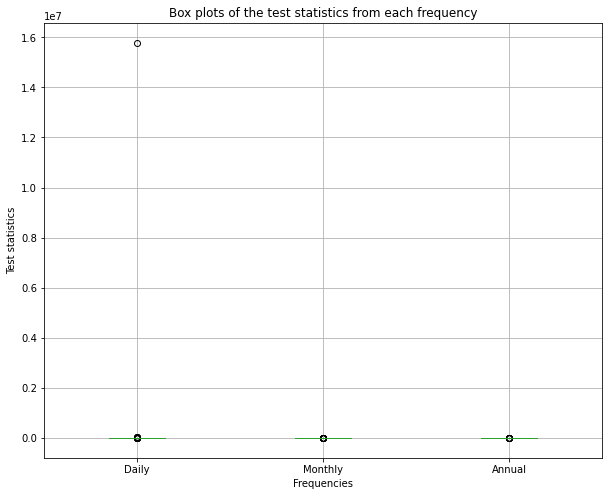

In [28]:
plt.figure(figsize=(10, 8))
comparison_df.boxplot()
plt.xlabel("Frequencies"); plt.ylabel("Test statistics")
plt.title("Box plots of the test statistics from each frequency")
plt.show()

> - We know if our data follows a normal distribution if the test statistic is close to zero and the p-value is larger than our standard 0.05
> - If the test statistic is large and the p-value is less than 0.05, the data does not follow a normal distribution
> - The jarque_bera function from Scipy computes the $p$-values from the c.d.f of the Chi-Squared distribution by assuming the number of samples are __at least 2000__
> - Therefore, it is recommended the sample sizes are large and at least greater than 2000 when using jb_test. This is so the data can be compared to the chi-squared distribution with 2 degrees of freedom. Anything __smaller could lead to a misleading test statistic and p-value__ (Referring to: https://towardsdatascience.com/jarque-bera-test-with-python-98677c073de3)

### For smaller $n$:
1. Use different normality tests
Such as __Shapiro-Wilk__ (for a sample size of less than 50)
Referring to:
> https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/  
> https://stats.stackexchange.com/questions/1645/appropriate-normality-tests-for-small-samples  
> https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6350423/  

2. Use __skewness__, __kurtosis__ and __standard errors__
Referring to:
> https://www.researchgate.net/publication/236049817_Statistical_notes_for_clinical_researchers_Assessing_normal_distribution_2_using_skewness_and_kurtosis  
which mentions "For small samples (n < 50), if absolute z-scores for either skewness or kurtosis are larger than 1.96, which corresponds with a alpha level 0.05, then reject the null hypothesis and conclude the distribution of the sample is non-normal"

3. Resort to a bootstrap

### Using Bootstrap for Jarque-Bera Test

In [29]:
# formula of jb_test
def jb(n, s, k):
    # n - number of samples
    # s - sample skewness
    # k - sample kurtosis
    return n/6.*(s**2 + ((k-3.)**2)/4.)

# implement jb_test
def jb_skew_kurtosis(n, bootstrap_samples):
    # calculate the skewness and kurtosis of the bootstraped samples
    s = stats.skew(bootstrap_samples)
    k = stats.kurtosis(bootstrap_samples, fisher=False)
    return jb(n,s,k)

# calculate the critical value based on percentile
def jb_critical_value(n, bootstrap_samples, p):
    return np.percentile(jb_skew_kurtosis(n, bootstrap_samples), (1.-p)*100.)

# implement the for each sample
def manual_jb_test(samples, p = 0.05):
    n = len(samples)
    # do bootstrapping
    bootstrap_samples = np.random.normal(size=(n, replications))
    # generate critical value and the test statistic
    critical_value = jb_critical_value(n, bootstrap_samples, p)
    s = stats.skew(samples)
    k = stats.kurtosis(samples, fisher=False)
    test_statistic = jb(n, s, k)
    # if the test_statistic is greater than the critical_value -> reject the null hypothesis (H_0)
    return (test_statistic > critical_value, test_statistic, critical_value)

In [30]:
# replication value for bootstrapping
# - bootstrapping is expensive -> choose appropriate value based on the given number of samples
replications = 10

# implement jb_test manually for simple_returns_daily
manual_jb_daily = simple_returns_daily.apply(lambda col : manual_jb_test(col))
manual_jb_daily.rename(index={0 : 'Reject', 1 : 'Test statistic', 2 : 'Critical value'}, inplace=True)
manual_jb_daily

,AAPL,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,AXP,BA,...,UNP,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM
Reject,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Test statistic,1704.289401,3006.261956,4169.884254,3701.263567,6396.550923,3092.145541,1416.113068,6660.371054,3230.776725,1305.922684,...,309.413152,4459.693632,1441.557747,1574.349578,9470.797306,614.232199,7034.611227,1139.864372,18297.706265,703.018949
Critical value,3.669436,4.515869,2.663988,2.821899,4.030337,7.750925,3.989078,4.936444,6.758555,2.251085,...,4.535832,7.820502,3.712481,3.686579,7.648278,3.040859,4.86867,4.025405,4.620908,6.535975


In [31]:
# replication value for bootstrapping
# - bootstrapping is expensive -> choose appropriate value based on the given number of samples
replications = 50

# implement jb_test manually for simple_returns_monthly
manual_jb_monthly = simple_returns_monthly.apply(lambda col : manual_jb_test(col))
manual_jb_monthly.rename(index={0 : 'Reject', 1 : 'Test statistic', 2 : 'Critical value'}, inplace=True)
manual_jb_monthly

,AAPL,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,AXP,BA,...,UNP,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM
Reject,False,True,False,False,True,True,False,False,True,False,...,True,False,False,False,True,False,True,False,False,False
Test statistic,0.44524,5.771278,2.600625,0.875737,105.261833,5.540848,0.176505,1.786452,32.26152,2.727917,...,9.637948,1.113221,3.859484,0.170822,24.105171,2.295268,8.041081,3.208357,2.081034,0.372233
Critical value,3.020353,4.965967,5.949289,4.91878,3.594854,3.853473,3.300383,5.79895,5.541429,5.032446,...,2.900745,7.805436,4.093281,5.344517,3.995701,3.079826,4.374554,5.018591,4.104069,5.337695


In [32]:
# replication value for bootstrapping
# - bootstrapping is expensive -> choose appropriate value based on the given number of samples
replications = 500

# implement jb_test manually for simple_returns_annual
manual_jb_annual = simple_returns_annual.apply(lambda col : manual_jb_test(col))
manual_jb_annual.rename(index={0 : 'Reject', 1 : 'Test statistic', 2 : 'Critical value'}, inplace=True)
manual_jb_annual

,AAPL,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,AXP,BA,...,UNP,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM
Reject,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
Test statistic,0.403659,0.031396,0.903042,0.239197,0.336965,0.784143,0.557826,0.325692,0.062392,1.214167,...,1.997791,1.096827,0.683304,0.337341,0.782212,0.7763,0.575165,0.642614,0.882684,0.857516
Critical value,1.766212,1.764341,2.017304,1.749178,1.672383,2.067134,2.008243,2.229457,2.13965,1.788286,...,1.82724,1.821669,1.843378,2.041993,1.750611,1.568724,1.799287,1.77692,2.167041,2.137732


In [33]:
# using counter, count the number of rejecting and accepting the null hypothesis
reject_ratios = [Counter(manual_jb_daily.loc['Reject']), Counter(manual_jb_monthly.loc['Reject']),
 Counter(manual_jb_annual.loc['Reject'])]

# put the outputs for each frequency together
reject_ratios = pd.DataFrame(reject_ratios, index=['Daily','Monthly','Annual'])
reject_ratios

,True,False
Daily,93,3
Monthly,25,71
Annual,6,90


### Conclusion
The table above shows that for:
> - __Daily simple returns__: most stocks' daily simple returns do not have normal distributions
> - __Monthly simple returns__: 1/3 of stocks' monthly simple returns do not have normal distributions while around 2/3 of stocks' simple returns have normal distribution
> - __Annually simple returns__: most stocks' annual simple returns have normal distributions while while few do not have normal distribution

Using Jarque-Bera test with bootstrapping due to the size of the samples

Referring to:
> Cont, R. (2001). Empirical properties of asset returns: stylized facts and statistical issues. Quantitative Finance, 1(2), 223–236. https://doi.org/10.1080/713665670

tells the definition of __Aggregational Gaussianity__ as
> "Aggregational Gaussianity: as one increases the time scale over which returns are calculated, their distribution looks more and more like a normal distribution. In particular, the shape of the distribution is not the same at different time scales."

That is, the longer the period (larger the time scale), the more the distribution (which is the simple returns of stocks in this case) looks like a normal distribution

Since the ratio of accepting the null hypothesis increases from daily to annual __our results support the claim that stock returns exhibit aggregational Gaussianity__

---

## Exercise 3
Download data for the S&P 100 index (symbol ^OEX), and repeat Exercise 1 with this data.

### Solution 3
> 1. Import S&P100 index data
> 2. Using log-returns function, which is created from Exercise 1, calculate index log-returns over daily, monthly and annual frequencies
> 3. Plot graphs for each log-returns
> 4. To check whether the returns are normally distributed, plot Histograms, Kernel Density Estimation (a probability density function) and Probability Plot for each log-return
    - Use KDE as it determines the shape of the distribution more efficiently than histograms
    - KDE does not have to depend on the number of bins used unlike  histograms
    - Use Probability Plot as well since probability plots are more specialised in determining by graphing z-scores (normal scores) against the data set
        * In Probability Plot, data is plotted against the theoretical normal distribution plot such that the plot forms an approximate straight line if the data is normally distributed (referring to: https://www.itl.nist.gov/div898/handbook/eda/section3/probplot.htm)

In [34]:
# set the start and end dates to download S&P100 data with the same time frame
start = datetime.datetime(2010, 1, 4)
end = datetime.datetime(2017, 11, 27)
# read the S&P 100 data from Yahoo
sp100index = data.DataReader("^OEX", "yahoo", start, end)
# take the adjusted closing prices
sp100index_prices = sp100index['Adj Close']

In [35]:
# check if any NaN values exist in the S&P 100 index data
sp100index_prices.isnull().values.any()

False

### Daily Index log-returns

In [36]:
# put sampling frequency = "D" for daily
# use last() for closing price and drop any NaN values for calculation
daily_index = sp100index_prices.resample('D').last().dropna()
daily_index_log_returns = log_returns(daily_index)

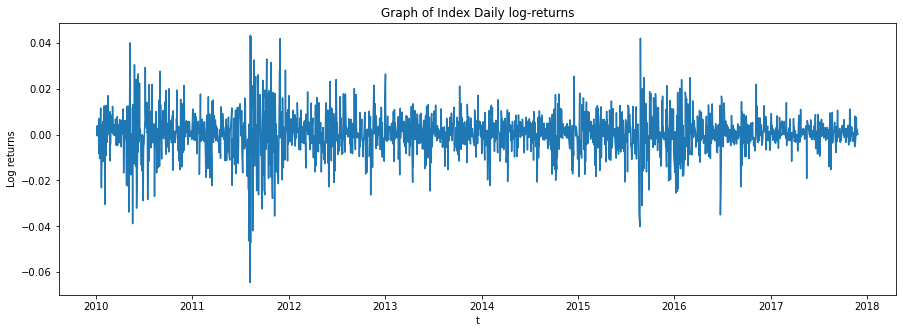

In [37]:
# set the figure size large
f = plt.figure() 
f.set_figwidth(15); f.set_figheight(5)

# plot the AAPL stock prices graph
plt.plot(daily_index_log_returns)

# label the graph
plt.xlabel("t"); plt.ylabel("Log returns")
plt.title("Graph of Index Daily log-returns")
plt.show()

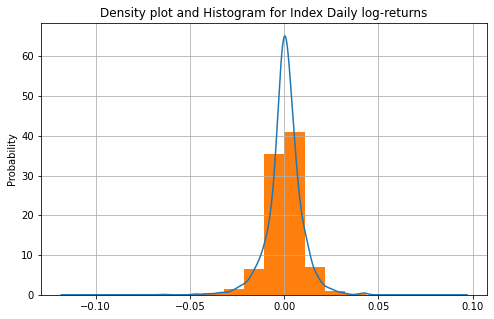

In [38]:
fig, ax = plt.subplots()

# update the size of the plot figure
fig.set_figwidth(8); fig.set_figheight(5)

# plot KDE
daily_index_log_returns.plot.kde(ax=ax, title='Density plot and Histogram for Index Daily log-returns')
# plot histogram
daily_index_log_returns.plot.hist(density=True, ax=ax)

#put label and grid
ax.set_ylabel('Probability'); ax.grid()

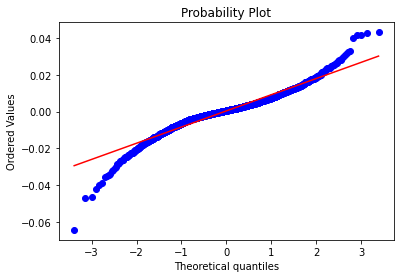

In [39]:
# plot probability plot for daily_index_log_returns
stats.probplot(daily_index_log_returns, dist='norm',plot=plt)
plt.show()

> The density plot and histogram above suggests that the daily index log-returns are __normally distributed__
> - The mean($\mu$) is around 0.0 and the curve is symmetric at the center
> - There is a little deviation of the histogram from the bell curve KDE distribution

> The probability plot above suggests that the daily index log-returns are __somewhat normally distributed__
> - The red straight line goes through the data's mean($\mu$) with a slope of the standard deviation($\sigma$) of the data used (referring to https://en.wikipedia.org/wiki/Normal_probability_plot)
> - The blue dots are fairly close to the red straight line ignoring large scale of the tails

### Monthly Index log-returns

In [40]:
# put sampling frequency = "M" for monthly
# use last() for closing price and drop any NaN values for calculation
monthly_index = sp100index_prices.resample('M').last().dropna()
monthly_index_log_returns = log_returns(monthly_index)

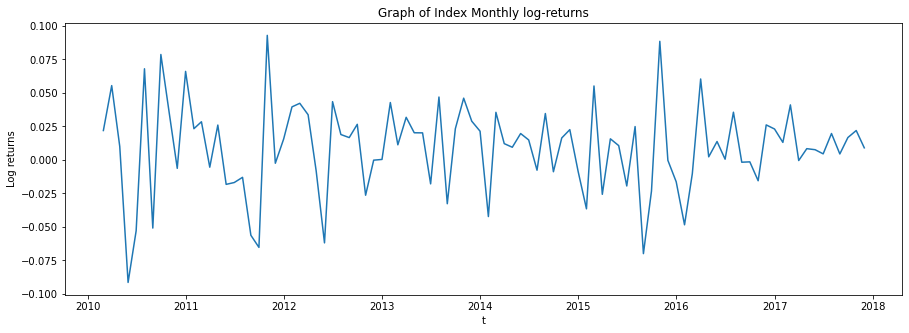

In [41]:
# set the figure size large
f = plt.figure() 
f.set_figwidth(15); f.set_figheight(5)

# plot the AAPL stock prices graph
plt.plot(monthly_index_log_returns)

# label the graph
plt.xlabel("t"); plt.ylabel("Log returns")
plt.title("Graph of Index Monthly log-returns")
plt.show()

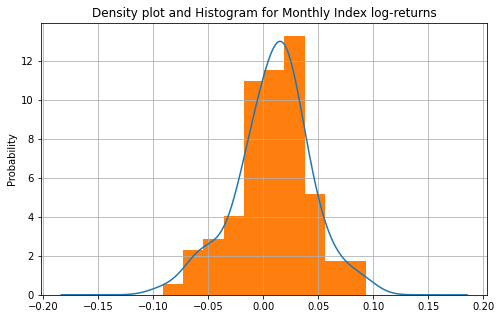

In [42]:
fig, ax = plt.subplots()

# update the size of the plot figure
fig.set_figwidth(8); fig.set_figheight(5)

# plot KDE
monthly_index_log_returns.plot.kde(ax=ax, title='Density plot and Histogram for Monthly Index log-returns')

# plot histogram
monthly_index_log_returns.plot.hist(density=True, ax=ax)

#put label and grid
ax.set_ylabel('Probability'); ax.grid()

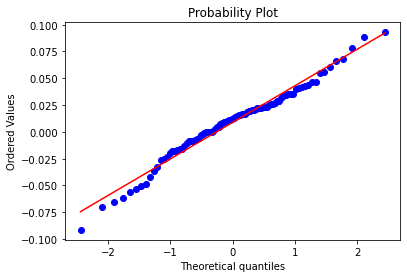

In [43]:
# plot probability plot for monthly_log_returns
stats.probplot(monthly_index_log_returns, dist='norm',plot=plt)
plt.show()

> The density plot and histogram above suggests that the monthly index log-returns are __barely normally distributed__
> - The mean($\mu$) is around 0.0 and the curve is almost symmetric at the center
> - There is a deviation of the histogram from the bell curve KDE distribution although the overall shape follows bell-curved normal distribution

> The probability plot above suggests that the monthly index log-returns are __hardly normally distributed__
> - The red straight line goes through the data's mean($\mu$) with a slope of the standard deviation($\sigma$) of the data used (referring to https://en.wikipedia.org/wiki/Normal_probability_plot)
> - The blue dots are fairly close to the red straight line ignoring largeer range of tails (than Daily Index log-returns)

In [44]:
# put sampling frequency = "A" for annual
# use last() for closing price and drop any NaN values for calculation
annual_index = sp100index_prices.resample('A').last().dropna()
annual_index_log_returns = log_returns(annual_index)

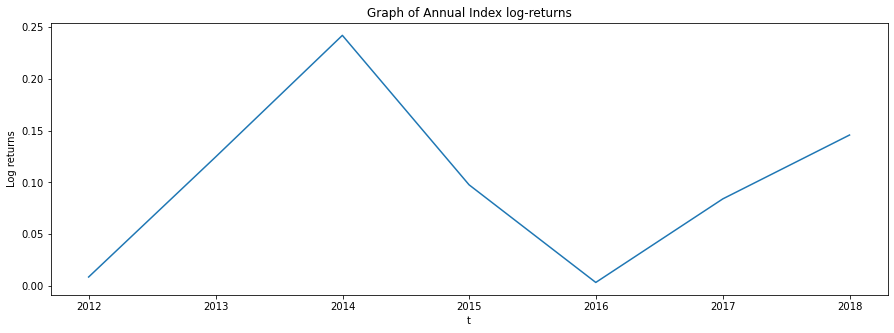

In [45]:
# set the figure size large
f = plt.figure() 
f.set_figwidth(15); f.set_figheight(5)

# plot the AAPL stock prices graph
plt.plot(annual_index_log_returns)

# label the graph
plt.xlabel("t"); plt.ylabel("Log returns")
plt.title("Graph of Annual Index log-returns")
plt.show()

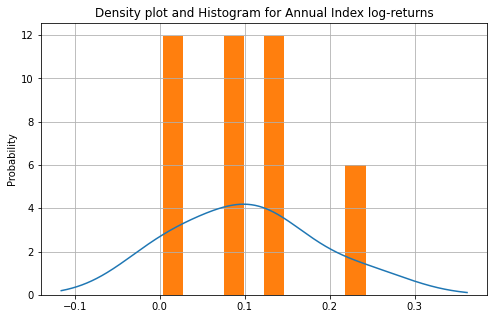

In [46]:
fig, ax = plt.subplots()

# update the size of the plot figure
fig.set_figwidth(8); fig.set_figheight(5)

# plot KDE
annual_index_log_returns.plot.kde(ax=ax, title='Density plot and Histogram for Annual Index log-returns')

# plot histogram
annual_index_log_returns.plot.hist(density=True, ax=ax)

#put label and grid
ax.set_ylabel('Probability'); ax.grid()

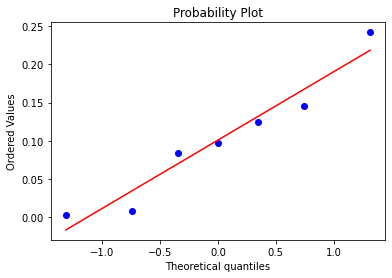

In [47]:
# plot probability plot for annual_log_returns
stats.probplot(annual_index_log_returns, dist='norm',plot=plt)
plt.show()

> The density plot and histogram above suggests that the annual index log-returns are __not normally distributed__
> - The curve is almost symmetric at the centre __but__
> - The mean($\mu$) is at 0.1 instead of 0.0
> - The shape of the histogram is significantly different from the shape of the density plot and does not display bell-curved shape at all

> The probability plot above suggests that the annual index log-returns are __hardly normally distributed__
> - The red straight line goes through the data's mean($\mu$) with a slope of the standard deviation($\sigma$) of the data used (referring to https://en.wikipedia.org/wiki/Normal_probability_plot)
> - The blue dots are fairly close to the red straight line but the lack of sample size barely suggests that the data follows normal distribution

---

## Exercise 4
Estimate the __$\alpha$ and $\beta$ of each stock__ according to the __single-index model__ using __ordinary least squares regression over monthly excess returns__, storing your results in a DataFrame. Produce a single graph showing side-by-side __boxplots summarising the distribution of the alpha and beta coefficients over all stocks in the index__.

### Solution 4
> 1. Import ols module from statsmodels.formula.api for ordinary least squares regression
> 2. Import data for monthly risk-free rates
> 3. Create single-index model for monthly excess returns
    * Create monthly index simple-return data using S&P 100
    * Use monthly index simple-return data, monthly stock prices simple-return data and risk-free rates to construct single index model for monthly excess returns
> 4. Use OLS to estimate $\alpha$ and $\beta$ of each stock
> 5. Plot box plot for summarising the distribution of the $\alpha$ and $\beta$ over all the stocks in S&P 100

### Single-Index Model
gives us that the return of a certain stock in an index at a certain time, follows the trend of an index quite closely

Referring to:
>Elton, E. J., & Gruber, M. J. (1997). Modern portfolio theory, 1950 to date. Journal of Banking and Finance, 21(11–12), 1743–1759. https://doi.org/10.1016/S0378-4266(97)00048-4

The formula is:

### $$ r_{i,t} - r_f = \alpha_i + \beta_i(r_{m,t} - r_f) + \epsilon_{i,t}$$

where the
* __alphas__: represents the abnormal return over holding the portfolio of an index fund and the treasury bills and,
* __betas__: represents the sensitivity of the associated stock

are parameters for the particular stocks

The formula tells us that __the return of a stock__ is roughly equal to __$\alpha$ + $\beta$ $*$ (the return of the index) + $\epsilon$__ where $\epsilon$ is a random variable that follows normal distribution

__=>__ that is, for this exercise, monthly excess returns of the index will be the independent variable ($X = r_{m,t} - r_f$) and the monthly excess returns of each stock will be the dependent variable ($Y = r_{i,t} - r_f$)

### Ordinary Least Squares regression (OLS)
is a technique for estimating coefficients of linear regression equations to describe the relationship between one or more independent variables and a dependent variable

The formula is:
### For $n$ observations - $$ (x_1,j,y_1),(x_2,j,y_2),...,(x_n,j,y_n) $$ over $$ j∈{1,2,...p}$$ regressors: $$ y_i=\alpha_i+\beta_1x_{i,1}+\beta_2𝑥_{i,2} + …+\beta_px_{i,p}+\epsilon_i $$

### Risk-Free Rates
Referring to:
> 1. https://www.educba.com/risk-free-rate-formula/
 - The risk free rate of a return is a theoretical return the investors expect to get when they make an investment with zero risks
 - "The calculation of risk free return depends on the time period for which the investment has been made."
 - Since the cash flows of S&P 100 is coming in the U.S, we should use the the long term rate on the US treasuries
 - From the article, an example of calculating risk free rate is provided:
     - "Treasury notes have the least amount of risk and are used as the risk free rate to understand the minimum rate of return that is to be expected on any investment"
     
> 2. https://www.risk.net/definition/risk-free-rate
- "Government bond yields are the most commonly used risk-free rates for assets."
- "Libor is a widely used proxy for a risk-free rate for swaps and bonds." => __therefore, choose bond yields for risk-free rates"__

> 3. https://factorpad.com/fin/quant-101/calculate-stock-returns.html
- For monthly excess returns, __the yield of 1 month US treasuries across 2010 to 2017 gives more precise risk-free rates for each month__ instead of __the United States 7-Year Bond Yield on the 4th of January 2010__ was __3.35%__
- Export and download the yields of 1 month US treasuries across the same time frame we have for the index data from https://www.wsj.com/market-data/quotes/bond/BX/TMUBMUSD01M/historical-prices# 

### Import Risk-Free Rates data

In [48]:
# download the historical risk-free rates from 2010-01-04 to 2017-11-27 data
# from https://www.wsj.com/market-data/quotes/bond/BX/TMUBMUSD01M/historical-prices# 
# and import the data back
US1MTB_Yield = pd.read_csv('US_1_Month_Treasury_Bill_Yield.csv')

# inverse the data to chronological order
US1MTB_Yield = US1MTB_Yield.iloc[::-1]

# for resampling, update the index to datetime index
US1MTB_Yield['Date'] = pd.to_datetime(US1MTB_Yield['Date'])
US1MTB_Yield.set_index('Date', inplace=True)

# pick up the closing risk-free rates and keep the monthly risk-free rates
US1MTB_Yield_closing = US1MTB_Yield[' Close']
monthly_rfr = pd.DataFrame(US1MTB_Yield_closing.resample('M').last()[1:]) # keep from 1: as the data will be compared with return data

### Create Single-Index Model with Monthly Data

In [49]:
# resample the index data to obtain monthly index data
sp100index_monthly_prices = sp100index['Adj Close'].resample('M').last()

In [50]:
# NaN values does not exist so move on
sp100index_monthly_prices.isnull().values.any()

False

In [51]:
# convert to log-return and to simple-return
index_log_returns = np.diff(np.log(sp100index_monthly_prices)) # log-returns
# update the index from 1: since the first row has no previous data to calculate the difference
index_log_returns_df = pd.DataFrame({'index': index_log_returns}, index=sp100index_monthly_prices.index[1:])
index_simple_returns_df = np.exp(index_log_returns_df) - 1. # simple returns

In [52]:
# put index monthly returns and monthly returns of each stock in S&P100 together
comparison_df = pd.concat([index_simple_returns_df, simple_returns_monthly], axis=1)

# subtract risk-free rate to obtain single-index model for monthly excess returns
monthly_excess_returns = comparison_df.sub(monthly_rfr[' Close'], axis='rows')

### Use OLS to calculate $\alpha$ and $\beta$ coefficients for each stock

In [53]:
# rename columns that have chance to cause errors in OLS to make eaiser to work with
monthly_excess_returns.rename(columns={"BRK-B":"BRK"}, inplace=True)

In [54]:
# to iterate over the column names, create a variable which has all the column names in monthly excess returns
mer_cols = list(monthly_excess_returns.columns)

In [55]:
# a function for returning the alpha and beta coefficients of each stock
def alphaBeta(col):
    f = col + " ~ index" # the order is dependent(stock or Y) ~ independent(index or X)
    result = ols(formula=f, data=monthly_excess_returns).fit()
    return result.params

# apply this function across each stock in index
params = pd.DataFrame(map(alphaBeta, mer_cols))
# update column headers and indices
params.columns = ['alpha', 'beta']; params.index = mer_cols
# first row gives coefficients of the stock index value so drop
params.drop('index', inplace=True)

### Plot box plot for summarising the distribution of the $\alpha$ and $\beta$ over all the stocks in S&P 100

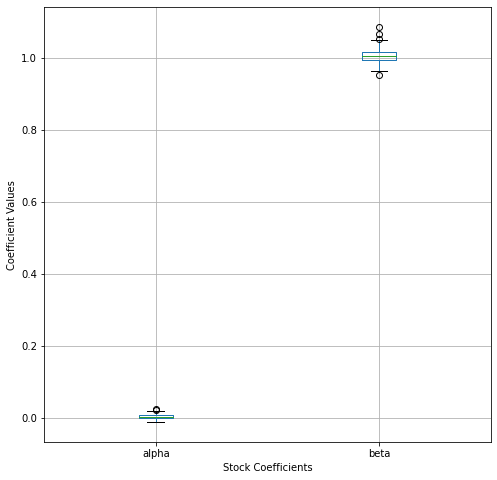

In [56]:
plt.figure(figsize=(8, 8))
params.boxplot()
plt.xlabel("Stock Coefficients"); plt.ylabel("Coefficient Values")
plt.show()

### Comment
>- alpha: alpha values across the stocks in the index are generally close to 0.0
>- beta: beat values across the stocks in the index are generally close to 1.0

This tells us that the stocks in the S&P100 index mostly do not have abnormal returns compared to the performance of the index, and moves and follows the trend of the index by its sensitivities proportional to the index by 1

---

## Exercise 5
Compute the __covariance matrix of the components of the index using the monthly excess-returns__. According to the single-index model (see Elton and Gruber 1997; reference below), __the covariance of a given pair of stocks should be directly proportional to the product of the corresponding $\beta$ values__. Test this hypothesis, and summarise your results in a single graph. Provide a written explanation of your results, and a short critical discussion

### Solution 5:
> 1. Compute the covariance matrix of the stocks of the index using the monthly excess-returns
> 2. Compute the product of the stocks' $\beta$ values
> 3. Pair the covariance of stocks and the corresponding pairs' beta product values
> 4. Plot scatter plot

### Compute Covariance Matrix

In [57]:
# compute covariance matrix
cov_monthly_excess_returns = monthly_excess_returns.cov()

# drop index returns
cov_monthly_excess_returns.drop(['index'], inplace=True, axis=0)
cov_monthly_excess_returns.drop(['index'], inplace=True, axis=1)

### Generate every beta products

In [58]:
# generate every pair of stocks' beta products
betas = pd.DataFrame(params['beta'])
betas_prod = betas.dot(betas.T)

### Generate pairs

In [59]:
pairs = []
for col in betas_prod.columns:
    pairs.append(list(zip(cov_monthly_excess_returns[col],betas_prod[col])))

from itertools import chain

pairs = list(chain.from_iterable(pairs))
pairs = pd.DataFrame(list(set(pairs)))

### Plot the Scatter Plot

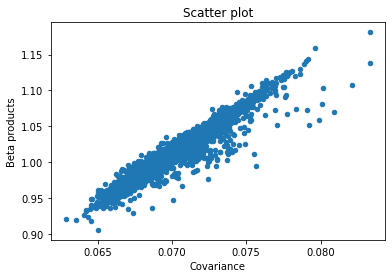

In [62]:
pairs.plot(x=0, y=1, kind='scatter')
plt.xlabel("Covariance"); plt.ylabel("Beta products")
plt.title("Scatter plot")
plt.show()